In [127]:
%matplotlib widget
import yfinance as yf
from pathlib import Path
from datetime import date, timedelta, datetime, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
import math

pd.options.mode.copy_on_write = True


def fetch_ticker(ticker="^GSPC", start="1990-01-01", interval="15m"):
    end = date.today()
    if interval == "1h":
        start = end - timedelta(days=720)
    p = Path(f"data/cache/{interval}/{ticker}.csv")
    p.parent.mkdir(parents=True, exist_ok=True)
    if not p.is_file() or date.fromtimestamp(p.stat().st_mtime) < date.today():
        data = yf.download(
            ticker, start=start, end=end, interval=interval, prepost=True
        )
        data.columns = data.columns.droplevel(-1)
        data.to_csv(p)
    else:
        data = pd.read_csv(p, index_col=0, parse_dates=[0])
    return data


df = fetch_ticker("^GSPC", interval="1d", start="1900-04-20")
df = df[df.index>'1985-01-01']

In [128]:
def plot_entry_and_exit_points(stock_data: pd.DataFrame, ma: int = 325):
    # Create a subplot with 2 rows: the upper row for price data, lower row for volume
    fig = make_subplots(
        rows=2,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        row_heights=[0.7, 0.3],
    )  # Adjust row heights as needed

    # --- Price Plot (Row 1) ---
    # Add closing price line
    fig.add_trace(
        go.Scatter(
            x=stock_data.index,
            y=stock_data["Close"],
            mode="lines",
            name="Closing Price",
            line=dict(color="blue"),
        ),
        row=1,
        col=1,
    )

    # Add moving average line
    fig.add_trace(
        go.Scatter(
            x=stock_data.index,
            y=stock_data[f"SMA_{ma}"],
            mode="lines",
            name="Moving Average",
            line=dict(color="yellow"),
        ),
        row=1,
        col=1,
    )
    # Add moving average line
    fig.add_trace(
        go.Scatter(
            x=stock_data.index,
            y=stock_data[f"SMA_50"],
            mode="lines",
            name="Moving Average",
            line=dict(color="white"),
        ),
        row=1,
        col=1,
    )
    # Add long entry and exit markers
    long_entry_indices = stock_data.index[stock_data["Long_Entry"]]
    long_entry_prices = stock_data["Close"][stock_data["Long_Entry"]]
    long_exit_indices = stock_data.index[stock_data["Long_Exit"]]
    long_exit_prices = stock_data["Close"][stock_data["Long_Exit"]]
    print(len(long_entry_indices))
    fig.add_trace(
        go.Scatter(
            x=long_entry_indices,
            y=long_entry_prices,
            mode="markers",
            name="Long Entry Signal",
            marker=dict(color="green", size=10, symbol="circle"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=long_exit_indices,
            y=long_exit_prices,
            mode="markers",
            name="Long Exit Signal",
            marker=dict(color="red", size=10, symbol="circle"),
        ),
        row=1,
        col=1,
    )

    # Plot holding period segments separately to avoid unwanted connections
    segments = []
    current_segment = []
    for i, row in stock_data.iterrows():
        if row["Position"] == True:
            current_segment.append(
                (i, row["Close"])
            )
        else:
            if current_segment:
                segments.append(current_segment)
                current_segment = []
    if current_segment:
        segments.append(current_segment)

    for segment in segments:
        x_vals, y_vals = zip(*segment)
        fig.add_trace(
            go.Scatter(
                x=x_vals,
                y=y_vals,
                mode="lines",
                name="Holding Period",
                line=dict(color="purple", width=3),
                opacity=0.8,
            ),
            row=1,
            col=1,
        )

    # Update layout for better viewing
    fig.update_layout(
        title="Stock Closing Price with Long Entry Signals and Volume",
        xaxis_title="Date",
        yaxis_title="Price",
        template="plotly_dark",
        hovermode="x unified",
        height=700,
    )
    # Set y-axis title for the volume subplot
    # fig.update_yaxes(title_text="Volume", row=2, col=1)

    fig.show()

In [129]:
def set_entry_and_exit(df:pd.DataFrame, moving_average: int, quick_moving_average:int):
    # Initialize entry and exit columns
    df["Long_Entry"] = False
    df["Long_Exit"] = False
    df["Position"] = False
    # Iterate starting from index 1 (because we use previous day's values)
    for i, idx in enumerate(df.index):
        if i == 0:
            continue
        prev_idx = df.index[i - 1]
        prev_sma50 = df.at[prev_idx, f"SMA_{quick_moving_average}"]
        prev_sma325 = df.at[prev_idx, "SMA_325"]
        # Retrieve previous day's values for Close and SMA
        prev_position = df.at[prev_idx, "Position"]

        if prev_position == False:
            if prev_sma50<=prev_sma325 and df.at[idx, f"SMA_{quick_moving_average}"] > df.at[idx, "SMA_325"]: #if prev_close and prev_close > prev_sma:
                df.at[idx, "Long_Entry"] = True
                df.at[idx, "Position"] = True
        else:
            if prev_sma50>prev_sma325 and df.at[idx, f"SMA_{quick_moving_average}"] <= df.at[idx, "SMA_325"]:# if prev_close < prev_sma and not weekly_entry:
                df.at[idx, "Long_Exit"] = True
                # Reset state upon exit
                df.at[idx, "Position"] = False
            else:
                df.at[idx, "Position"] = True

In [131]:
moving_average = 325
quick_moving_average = 50
df["daily_return"] = df["Close"].pct_change().fillna(0)
df[f"SMA_{moving_average}"] = (
    df["Close"]
    .rolling(window=moving_average, min_periods=moving_average)
    .mean()
)
df[f"SMA_{quick_moving_average}"] = (
    df["Close"]
    .rolling(window=quick_moving_average, min_periods=quick_moving_average)
    .mean()
)
df['weekly_cum_return'] = (1 + df['daily_return']).rolling(window=5).apply(np.prod, raw=True) - 1
set_entry_and_exit(df, moving_average, quick_moving_average)
signal = df['Close'].shift(1) > df[f'SMA_{moving_average}'].shift(1)
# df['Long_Entry'] = signal & (~signal.shift(1, fill_value=False))

# # Long exit occurs when signal turns False (i.e. yesterday it was True)
# df['Long_Exit'] = (~signal) & (signal.shift(1, fill_value=False))
# df['Position'] = (df['Long_Entry'].astype(int).cumsum() > df['Long_Exit'].astype(int).cumsum()).astype(bool)
df["is_first"] = (
    df.index.to_series()
    .groupby([df.index.year, df.index.month])
    .transform("min")
    == df.index
)
df["overnight_pct_change"] = np.where(
    df["Open"] == 0,
    0,
    (df["Open"] - df["Close"].shift(1)) / df["Close"].shift(1)
)
df.dropna(inplace=True)

In [132]:
plot_entry_and_exit_points(df, moving_average)

12


In [133]:
class Depot:
    cash: float
    shares: float
    leverage_factor: int
    history: list[float]
    leveraged: bool = False
    cert_units: float
    invested_cash: int  # only tracks the cash amount invested
    buy_in: float
    tax_allowance: float # Größe des Verlusttopfs. Negativwerte = gezahlte Steuern
    depot_runtime: int # how long the depot exists in days, used for tax allowance
    strategy: bool # indicates if the depot is applying the sma strategy
    paid_taxes: float # tracks taxes for debugging

    def __init__(self, starting_cash: float, leverage_factor: int = 1, strategy:bool=False):
        self.cash = starting_cash
        self.invested_cash = starting_cash
        self.leverage_factor = leverage_factor
        self.history = []  # to record daily portfolio value
        self.invest_history = []  # to record daily portfolio value
        if leverage_factor == 1:
            self.leveraged = False
            self.shares = 0.0
        else:
            self.leveraged = (
                True  # uses certificate units and a certificate price
            )
            self.cert_units = 0.0
            self.cert_price = 1.0  # start at an arbitrary value
        self.tax_allowance = 1000
        self.buy_in = 0
        self.depot_runtime = 0
        self.strategy = strategy
        self.paid_taxes = 0

    def deposit(self, amount, price=None):
        # print(f"BUY! - {amount}")
        if amount > self.cash:
            raise ValueError(
                "Not enough cash! Cash: %s - Investment: %s", self.cash, amount
            )
        if not self.leveraged:
            if price is None:
                raise ValueError("Price is required for unleveraged deposit.")
            # Buy shares at the current price.
            buy_price_with_spread = price*1.01
            buy_amount = amount/buy_price_with_spread
            # print(f"buy_price: {buy_price_with_spread} - amount: {buy_amount}")
            self.shares += buy_amount
        else:
            # In leveraged mode, deposit buys certificate units at the current certificate price.
            buy_price_with_spread = self.cert_price *1.01 # add 1% spread
            buy_amount = math.floor(amount / (
                buy_price_with_spread
            ))
            self.cert_units += buy_amount
        self.cash -= buy_amount*buy_price_with_spread
        # as we always look at the full portfolio value for profit calculations
        # we can just deduct the certificate fees from cash
        self.buy_in += buy_amount*buy_price_with_spread
        # print(f"buy in: {self.buy_in} - buy_amount: {buy_amount}")

    def add_cash(self, amount: float):
        self.cash += amount
        self.invested_cash += amount

    def calculate_tax(self, sold_position: float):
        profit = sold_position - self.buy_in
        if profit > 0:
            # Calculate tax due as 25% of the profit.
            tax = profit * 0.25
            # If there's a positive tax_allowance, offset the tax by that amount.
            if self.tax_allowance > 0:
                offset = min(self.tax_allowance, tax)
                self.tax_allowance -=offset
                tax -= offset
            # if tax wasn't fully offset, 
            if tax > 0:
                self.tax_allowance -= tax
        else:
            tax = 0
            loss = abs(profit)
            # For losses, tax is 0.
            # If tax_allowance is negative, that indicates you previously paid taxes.
            # Refund those taxes (the absolute value of tax_allowance) into cash.
            if self.tax_allowance < 0:
                refund = min(abs(self.tax_allowance), loss)
                self.cash += refund
            self.tax_allowance += loss
        # print(f"allowance: {self.tax_allowance} tax: {tax} profit:{profit}")
        return tax

    def sell_all(self, price=None, overnight_chg: float=None):
        # print("Cash before: ", self.cash)
        if not self.leveraged:
            if price is None:
                raise ValueError("Price is required for unleveraged sell_all.")
            # Sell all shares at the current price.
            sold_position = self.shares * price
            self.cash += sold_position
            self.shares = 0.0
        else:
            cert_price = self.cert_price
            # print(f"Overnight chg: {overnight_chg} - lev: {self.leverage_factor} - cert: {cert_price}")
            if overnight_chg:
                # calculate cert value on open
                cert_price *= 1+self.leverage_factor*overnight_chg
                # print(f"cert after: {cert_price}")
            # Sell all certificate units.
            sold_position = self.cert_units * (
                cert_price * (1-0.01)
            )  # add 1% spread
            self.cash += sold_position
            self.cert_units = 0.0
        # print("OVERNIGHT: ", cert_price)
        tax = self.calculate_tax(sold_position)
        self.buy_in = 0  # assuming we always sell 100%
        self.cash -= tax
        self.paid_taxes += tax
        # print("Cash after: ", self.cash)

    def update(self, daily_return):
        # In unleveraged mode nothing changes (share count is fixed; value comes from current price).
        # In leveraged mode, update the certificate price by applying the leveraged daily return.
        if self.leveraged:
            self.cert_price *= 1 + self.leverage_factor * daily_return
            # reduce value of option by fee:
            self.cert_price *= 1-0.00003  # 0.75%/annual = 0.00003/Tag
            self.cert_price *= 1-0.0000196  # transactioncosts: 0.49%/annual
        # dca does not sell until the end, so we only need to care about tax allowance for the lev strategies
        if self.strategy and self.depot_runtime % 250==0 and self.depot_runtime > 0:
            self.tax_allowance = 1000 



    def get_portfolio_value(self, price=None):
        if not self.leveraged:
            if price is None:
                raise ValueError(
                    "Price is required to compute portfolio value in unleveraged mode."
                )
            return self.cash + self.shares * price
        else:
            return self.cash + self.cert_units * self.cert_price

    def record_value(self, price=None):
        # Record the current portfolio value into the history.
        val = self.get_portfolio_value(price)
        self.history.append(val)
        self.invest_history.append(self.invested_cash)

    def is_invested(self):
        if not self.leveraged:
            return self.shares > 0
        else:
            return self.cert_units > 0

In [134]:
def simulate_investments(
    df: pd.DataFrame,
    investment: int = 100,
    start_invest: int = 10000,
    leverage: int = 1,
    strategy: bool = False,
) -> tuple[list[int], list[int], int]:
    start_price = df["Close"][0]
    depot = Depot(start_invest, leverage_factor=leverage, strategy=strategy)
    depot.deposit(depot.cash, start_price)

    # --- 3. Simulate Daily Portfolio Values ---
    for idx, row in df.iterrows():
        # print(f"{idx}: position: {depot.shares}/{row['Close']} -  cash: {depot.cash}")
        if row["is_first"]:
            depot.add_cash(investment)
            if (strategy and row["Position"] == True) or not strategy:
                depot.deposit(depot.cash, row["Close"])

        if strategy and row["Long_Exit"]==True and depot.is_invested():
            depot.sell_all(row["Close"], row["overnight_pct_change"])
            # print(depot.cash)

        if strategy and row["Long_Entry"]==True and not depot.is_invested():
            depot.deposit(depot.cash, row["Close"])

        # update cert value every day
        depot.update(row["daily_return"])
        depot.record_value(row["Close"])
    depot.sell_all(row["Close"])
    depot.record_value(row["Close"])
    # print(depot.paid_taxes)
    return depot.history, depot.invest_history, depot.paid_taxes

In [135]:
# monte_carlo_results
a,b,c = simulate_investments(df[(df.index>='2015-01-26') & (df.index<='2025-01-26')],strategy=False, leverage=1)
a[-1], b[-1], c


/tmp/ipykernel_3004/597065285.py:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



(np.float64(46372.78817283958), 22000, np.float64(6790.929390946527))

In [136]:
# df[(df.index>='1981-07-09') & (df.index<='1991-07-09')][290:340]

In [137]:
plan_configs = {
    "dca": {"leverage": 1, "strategy": False},
    "dca_lev_x2": {"leverage": 2, "strategy": False},
    "dca_lev_x3": {"leverage": 3, "strategy": False},
    "sma": {"leverage": 1, "strategy": True},
    "sma_lev_x2": {"leverage": 2, "strategy": True},
    "sma_lev_x3": {"leverage": 3, "strategy": True},
}

In [138]:
def calc_max_drawdown(portfolio_values, cash_values):
    """
    Given a sequence of portfolio values and cash states, compute the maximum drawdown.
    Returns the minimum drawdown (a negative percentage).
    """
    values = np.array(portfolio_values)
    running_max = np.maximum.accumulate(cash_values)
    drawdowns = (values - running_max) / running_max
    return drawdowns.min()

def calc_final_profit(portfolio_values, invested_cash):
    """
    Computes the final profit as a percentage gain/loss.
    """
    values = np.array(portfolio_values)
    return values[-1] / invested_cash - 1

In [139]:
def monte_carlo_simulation_for_plans(
    df: pd.DataFrame,
    horizon_years: int,
    num_simulations: int,
    plan_configs: dict,
    start_invest: int=10000,
    investment:int = 1000
) -> dict[pd.DataFrame]:
    """
    Run Monte Carlo simulations for a given plan.
    
    Parameters:
      df: DataFrame with your trading data. It must have a DateTimeIndex and required columns.
      horizon_years: The length of each simulation (in years).
      num_simulations: How many simulations to run.
      investment: Monthly contribution.
      start_invest: Initial cash (starting investment).
      leverage: Leverage factor.
      strategy: If True, use SMA-based strategy; otherwise use DCA.
      
    Returns:
      A DataFrame with the final profit and maximum drawdown for each simulation.
    """
    results:dict[list] = {}
    # Create a DateOffset for the horizon.
    horizon_offset = pd.DateOffset(years=horizon_years)
    data = df.copy() # ensure original is not edited
    # Get possible start dates (all dates for which start_date + horizon is before last date).
    possible_starts = data.index[data.index <= (data.index[-1] - horizon_offset)]
    possible_starts = possible_starts.to_numpy()
    
    if len(possible_starts) == 0:
        raise ValueError("Not enough data for the given horizon.")
    for plan_name in plan_configs.keys():
        results[plan_name] = list()
    
    for i in range(num_simulations):
        start_date = np.random.choice(possible_starts)
        end_date = start_date + horizon_offset
        data_sub = data.loc[start_date:end_date]
        # Skip simulation if the slice is too short.
        if len(data_sub) < 10:
            continue
        for plan_name, config in plan_configs.items():
            portfolio_history, cash_history, paid_taxes = simulate_investments(
                data_sub,
                investment=investment,
                start_invest=start_invest,
                leverage=config["leverage"],
                strategy=config["strategy"],
            )
            final_profit = calc_final_profit(portfolio_history, cash_history[-1])
            max_dd = calc_max_drawdown(portfolio_history, cash_history)
            results[plan_name].append({
                "final_profit": final_profit,
                "max_drawdown": max_dd,
                "start_date": start_date,
                "end_date": data_sub.index[-1],
                "paid_taxes":paid_taxes
            })
    for plan_name in plan_configs.keys():
        results[plan_name] = pd.DataFrame(results[plan_name])
    return results


In [140]:
horizons = [1, 3, 5, 10, 20]
num_simulations = 200
investment = 1000
start_invest = 10000
monte_carlo_results = {}

for horizon in tqdm(horizons):
    monte_carlo_results[horizon] = monte_carlo_simulation_for_plans(
        df,
        horizon,
        num_simulations,
        plan_configs=plan_configs,
        start_invest=start_invest,
        investment=investment,
    )

    # Print summary statistics

  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_3004/597065285.py:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



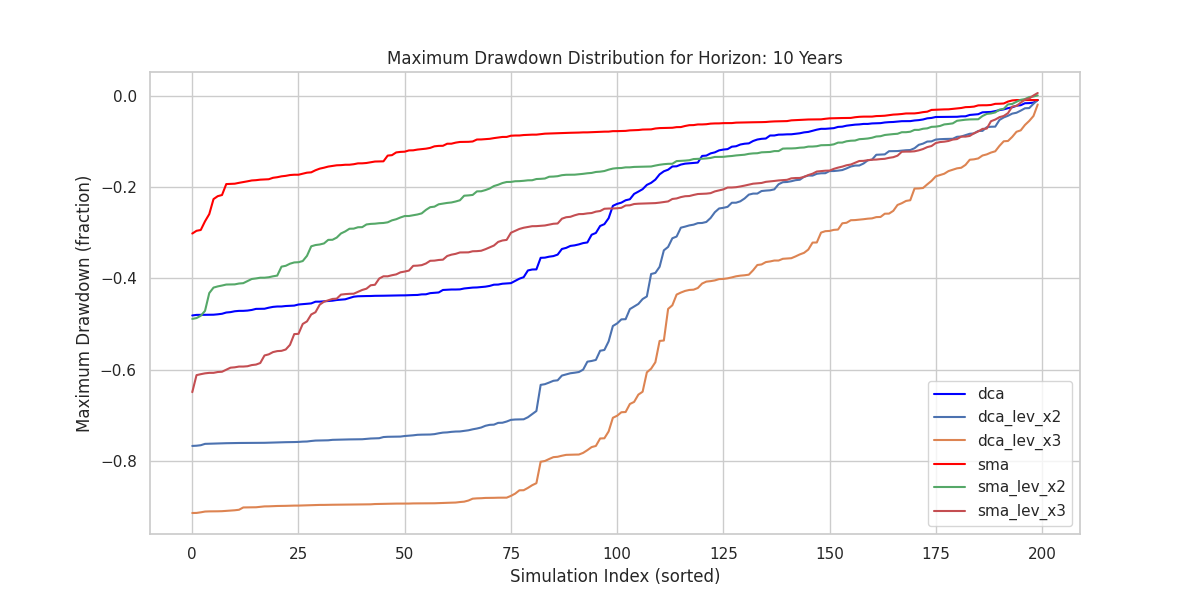

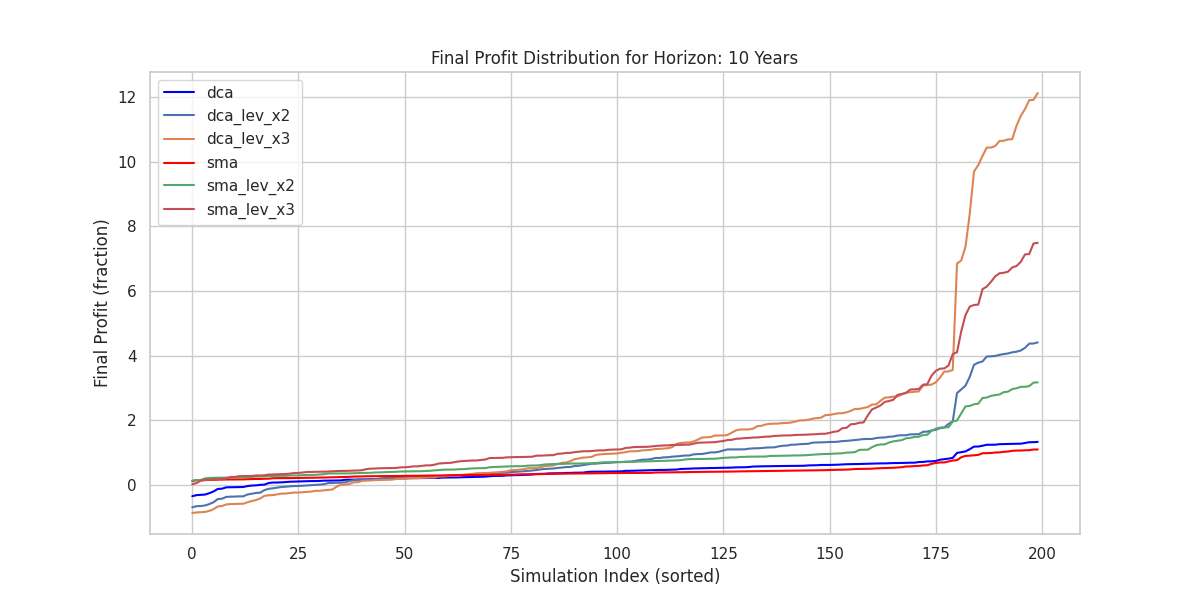

In [141]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

# For example, choose a single horizon (e.g., 10 years)
horizon = 10
results_for_horizon = monte_carlo_results[horizon]

# Define a color mapping for the strategies.
colors = {
    "cash": "black",
    "dca": "blue",
    "dca_lev": "green",
    "dca_lev2": "orange",
    "sma": "red",
    "sma_lev": "purple",
    "sma_lev2": "brown"
}

# --- Graph 1: Final Profit ---
fig1, ax1 = plt.subplots(figsize=(12, 6))
for plan_name, sim_df in results_for_horizon.items():
    # Sort the final profit values for a smooth line
    sorted_profit = np.sort(sim_df["final_profit"].values)
    x = np.arange(len(sorted_profit))
    ax1.plot(x, sorted_profit, label=plan_name, color=colors.get(plan_name, None))
    
    # # Calculate mean and median
    # mean_profit = np.mean(sorted_profit)
    # median_profit = np.median(sorted_profit)
    
    # # Overlay horizontal lines for mean (dashed) and median (dotted)
    # ax1.axhline(mean_profit, color=colors.get(plan_name, None), linestyle="--")
    # ax1.axhline(median_profit, color=colors.get(plan_name, None), linestyle=":")
    
ax1.set_xlabel("Simulation Index (sorted)")
ax1.set_ylabel("Final Profit (fraction)")
ax1.set_title(f"Final Profit Distribution for Horizon: {horizon} Years")
ax1.legend()
ax1.grid(True)

# --- Graph 2: Maximum Drawdown ---
fig2, ax2 = plt.subplots(figsize=(12, 6))
for plan_name, sim_df in results_for_horizon.items():
    # Sort the max_drawdown values for a smooth line
    sorted_dd = np.sort(sim_df["max_drawdown"].values)
    x = np.arange(len(sorted_dd))
    ax2.plot(x, sorted_dd, label=plan_name, color=colors.get(plan_name, None))
    
    # # Calculate mean and median
    # mean_dd = np.mean(sorted_dd)
    # median_dd = np.median(sorted_dd)
    
    # # Overlay horizontal lines for mean (dashed) and median (dotted)
    # ax2.axhline(mean_dd, color=colors.get(plan_name, None), linestyle="--")
    # ax2.axhline(median_dd, color=colors.get(plan_name, None), linestyle=":")
    
ax2.set_xlabel("Simulation Index (sorted)")
ax2.set_ylabel("Maximum Drawdown (fraction)")
ax2.set_title(f"Maximum Drawdown Distribution for Horizon: {horizon} Years")
ax2.legend()
ax2.grid(True)

plt.show()


In [142]:
results_for_horizon["dca_lev_x3"].sort_values(by=["end_date"]), results_for_horizon["sma_lev_x3"].sort_values(by=["end_date"])

(     final_profit  max_drawdown start_date   end_date     paid_taxes
 182      6.845840     -0.776006 1987-08-12 1997-08-12  295319.750515
 70      10.176586     -0.159298 1988-03-11 1998-03-11  439652.058373
 105     11.626726     -0.203309 1988-07-06 1998-07-06  502491.445986
 58       8.390071     -0.194349 1988-10-31 1998-10-30  362236.419064
 9        9.695804     -0.202333 1988-12-12 1998-12-11  418818.192907
 ..            ...           ...        ...        ...            ...
 76       2.351440     -0.397950 2014-07-18 2024-07-18  100562.420854
 1        2.351428     -0.407157 2014-09-16 2024-09-16  100561.901393
 111      2.881304     -0.421107 2015-01-22 2025-01-22  123523.178222
 109      2.730253     -0.424828 2015-01-27 2025-01-27  116977.619836
 81       2.156874     -0.435559 2015-03-06 2025-03-06   92131.199829
 
 [200 rows x 5 columns],
      final_profit  max_drawdown start_date   end_date     paid_taxes
 182      3.692691     -0.649090 1987-08-12 1997-08-12  143403.

In [143]:
results = {}
for plan in plan_configs.keys():
    results[plan] = dict()
    for key, value in monte_carlo_results.items():
        results[plan][key] = dict()
        for column in value[plan].columns:
            if column in ["start_date","end_date"]:
                continue
            results[plan][key][column] = value[plan][column].median()
            # print(f"{plan} - profit: {value[plan][column].median()}")

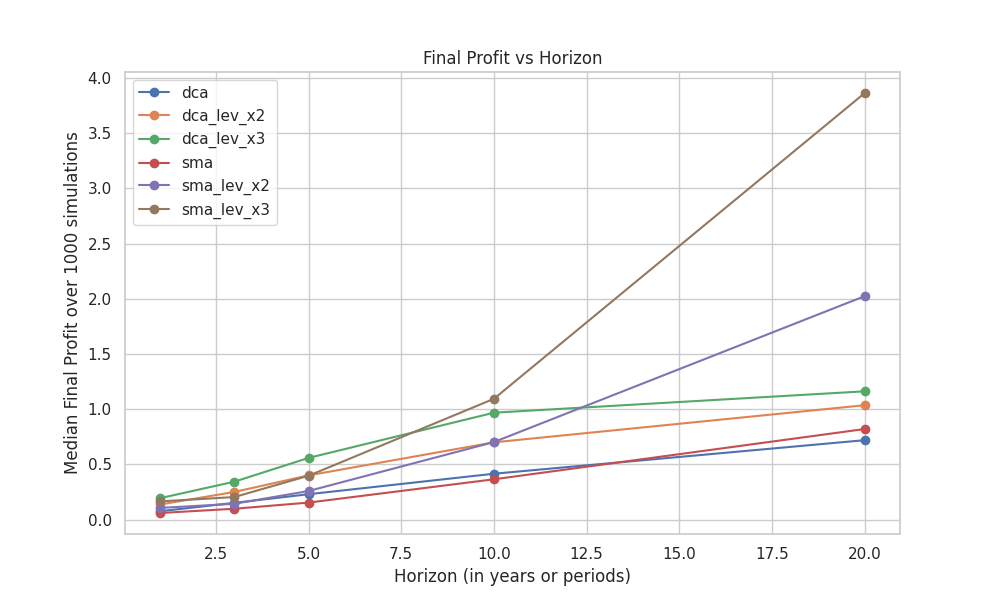

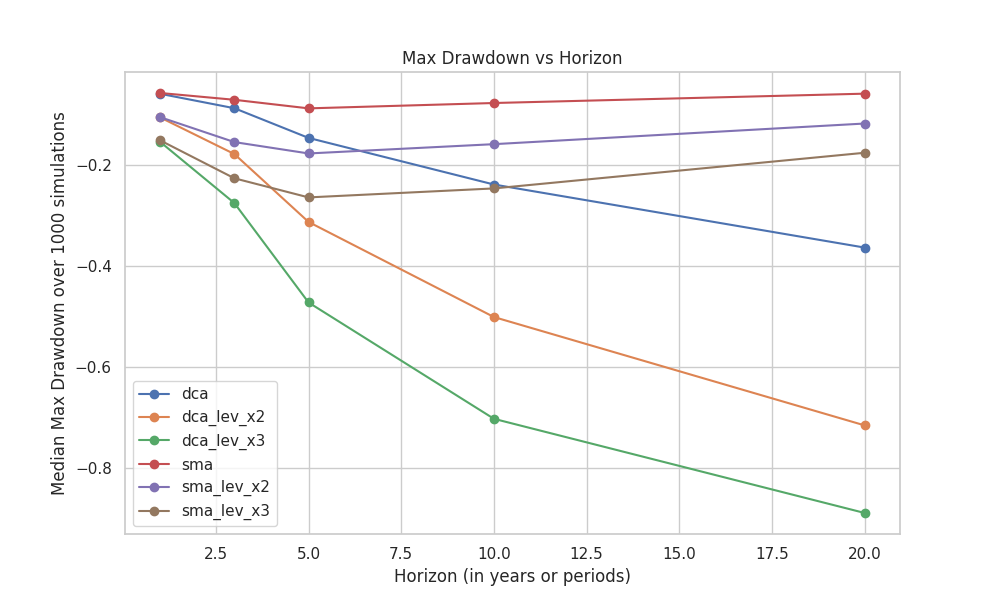

In [144]:
plt.figure(figsize=(10, 6))
for plan, horizons in results.items():
    # Sort horizons for proper plotting
    x = sorted(horizons.keys())
    y = [horizons[h]['final_profit'] for h in x]
    plt.plot(x, y, marker='o', label=plan)
    
plt.xlabel("Horizon (in years or periods)")
plt.ylabel("Median Final Profit over 1000 simulations")
plt.title("Final Profit vs Horizon")
plt.legend()
plt.grid(True)
plt.show()

# -------------------
# Plot for Max Drawdown
# -------------------
plt.figure(figsize=(10, 6))
for plan, horizons in results.items():
    x = sorted(horizons.keys())
    y = [horizons[h]['max_drawdown'] for h in x]
    plt.plot(x, y, marker='o', label=plan)
    
plt.xlabel("Horizon (in years or periods)")
plt.ylabel("Median Max Drawdown over 1000 simulations")
plt.title("Max Drawdown vs Horizon")
plt.legend()
plt.grid(True)
plt.show()

In [145]:
import pandas as pd

summary_list = []
for horizon, strat_dict in monte_carlo_results.items():
    for strat, df in strat_dict.items():
        stats = {
            'horizon': horizon,
            'strategy': strat,
            'profit_median': df['final_profit'].median(),
            'profit_mean': df['final_profit'].mean(),
            'profit_std': df['final_profit'].std(),
            'profit_q25': df['final_profit'].quantile(0.25),
            'profit_q75': df['final_profit'].quantile(0.75),
            'drawdown_median': df['max_drawdown'].median(),
            'drawdown_mean': df['max_drawdown'].mean(),
            'taxes_median': df['paid_taxes'].median(),
        }
        summary_list.append(stats)
        
summary_df = pd.DataFrame(summary_list)


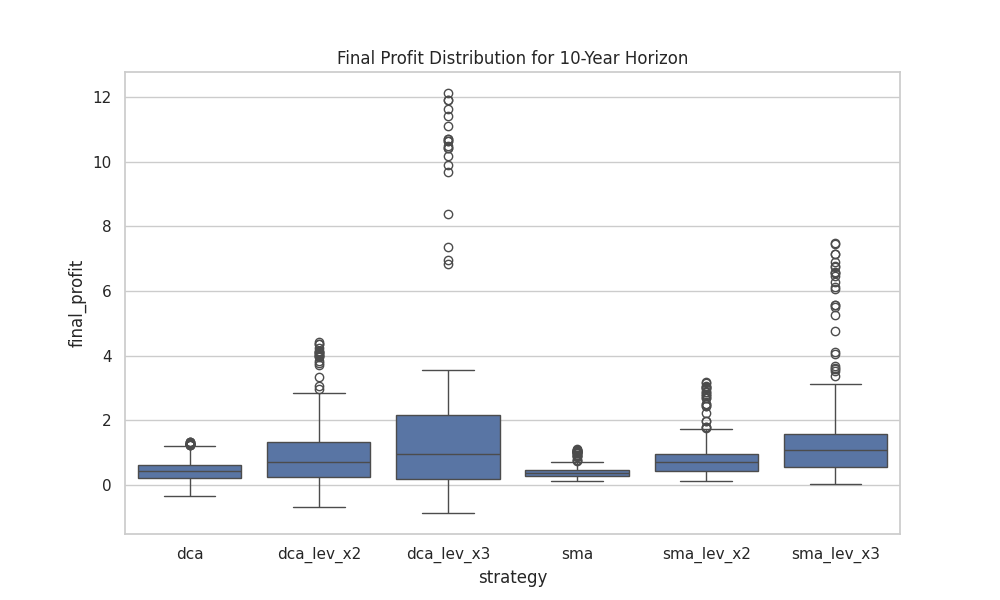

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results for a given horizon into a single DataFrame for visualization.
horizon = 10  # for example
data_list = []
for strat, df in monte_carlo_results[horizon].items():
    temp = df[['final_profit']].copy()
    temp['strategy'] = strat
    data_list.append(temp)
    
viz_df = pd.concat(data_list)
plt.cla()
sns.boxplot(x='strategy', y='final_profit', data=viz_df)
plt.title(f'Final Profit Distribution for {horizon}-Year Horizon')
plt.show()

In [147]:
summary_df['risk_adjusted'] = summary_df['profit_median'] / summary_df['drawdown_median'].abs()
print(summary_df[['horizon', 'strategy', 'profit_median', 'drawdown_median', 'risk_adjusted', 'taxes_median']])


    horizon    strategy  profit_median  drawdown_median  risk_adjusted  \
0         1         dca       0.076188        -0.059662       1.277001   
1         1  dca_lev_x2       0.137088        -0.106508       1.287113   
2         1  dca_lev_x3       0.194534        -0.154942       1.255528   
3         1         sma       0.060017        -0.058079       1.033376   
4         1  sma_lev_x2       0.106110        -0.105986       1.001165   
5         1  sma_lev_x3       0.164970        -0.151900       1.086040   
6         3         dca       0.151973        -0.088219       1.722680   
7         3  dca_lev_x2       0.250620        -0.178930       1.400657   
8         3  dca_lev_x3       0.343730        -0.275975       1.245511   
9         3         sma       0.098585        -0.071523       1.378366   
10        3  sma_lev_x2       0.143415        -0.155245       0.923794   
11        3  sma_lev_x3       0.204545        -0.226890       0.901516   
12        5         dca       0.230081

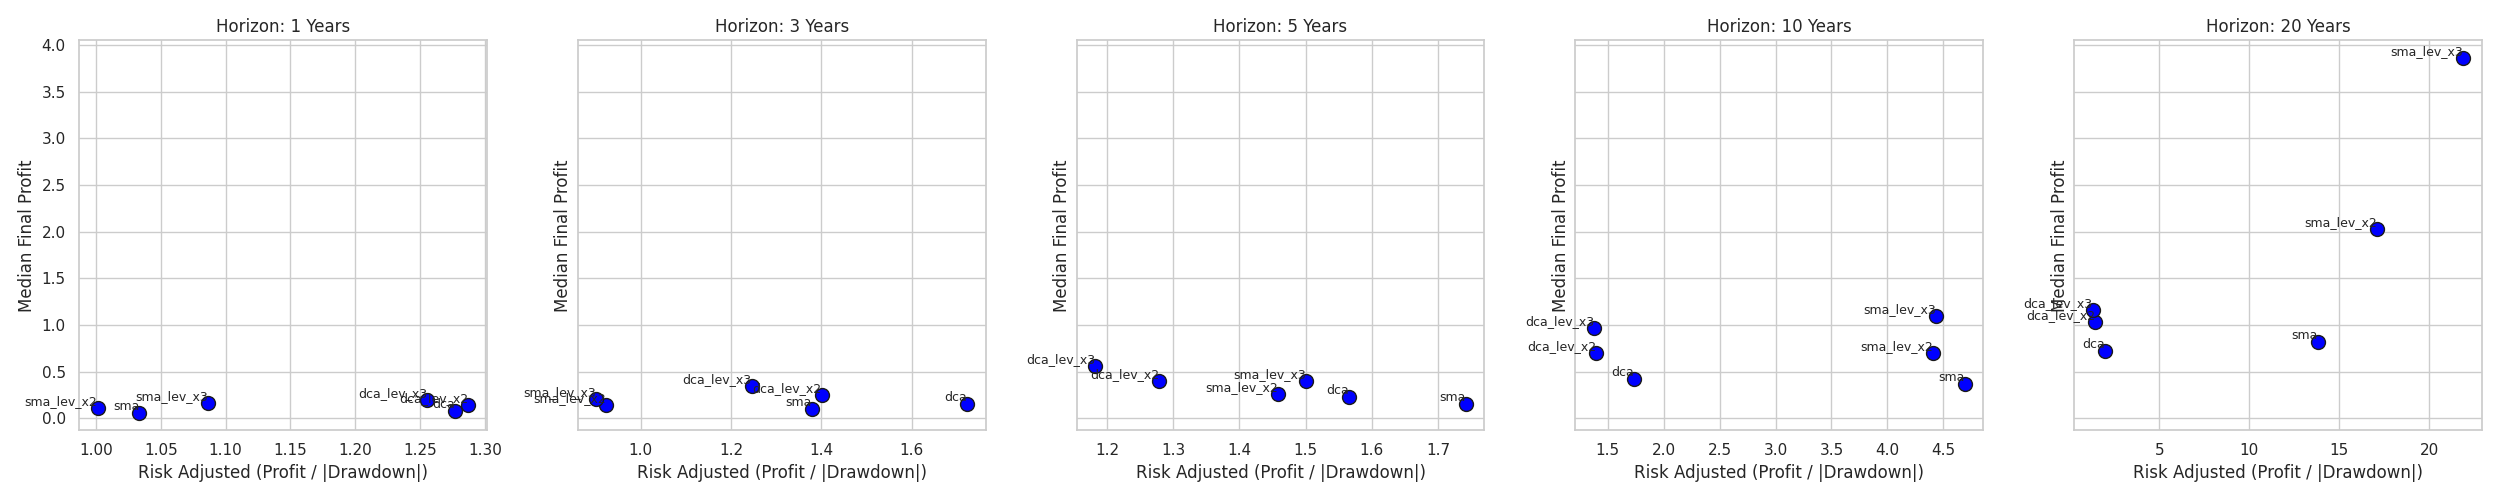

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming summary_df has columns: 'horizon', 'strategy', 'profit_median', 'drawdown_median'
# Calculate the risk-adjusted value (the higher, the better: more profit per unit risk)
summary_df['risk_adjusted'] = summary_df['profit_median'] / summary_df['drawdown_median'].abs()

# Get the unique horizons and sort them
horizons = sorted(summary_df['horizon'].unique())
n_horizons = len(horizons)

# Set a nice style for readability
sns.set(style="whitegrid")

# Create subplots (one per horizon)
fig, axes = plt.subplots(1, n_horizons, figsize=(5 * n_horizons, 5), sharey=True)
if n_horizons == 1:
    axes = [axes]

for ax, horizon in zip(axes, horizons):
    # Filter the data for the given horizon
    data = summary_df[summary_df['horizon'] == horizon]
    
    # Create a scatter plot with x=risk_adjusted and y=profit_median
    ax.scatter(data['risk_adjusted'], data['profit_median'], s=100, color='blue', edgecolor='k')
    
    # Annotate each point with the strategy name
    for _, row in data.iterrows():
        ax.text(row['risk_adjusted'], row['profit_median'], row['strategy'], 
                fontsize=9, ha='right', va='bottom')
    
    ax.set_title(f'Horizon: {horizon} Years')
    ax.set_xlabel('Risk Adjusted (Profit / |Drawdown|)')
    ax.set_ylabel('Median Final Profit')

plt.tight_layout()
plt.show()
